# LSTM on Amazon Food Reviews

In [20]:
#import libraries.....
import time
import sqlite3
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from sklearn.preprocessing import normalize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import scipy as sp
from scipy import sparse
import tqdm
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import pad_sequences
# fix random seed for reproducibility
numpy.random.seed(7)

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, fig):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [5]:
# using the SQLite Table to read data.
# The below SQlite file consists of 60000 rows with Time based splitting and Summary column preprocessed[Feature Engineering].
con = sqlite3.connect('./final_tbs_cleansummary_text.sqlite')

final_tbs=pd.read_sql_query("""select * from Reviews""",con) # The table was preprocessed with time based splitting.
con.close()

final_tbs.head(5)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary,Cleaned_Text_stop,Cleaned_Summary_stop
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ,this witti littl book make son laugh loud reci...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child,can rememb see the show when air televis year ...,this whole seri great way spend time with your...
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni,beetlejuic well written movi everyth about exc...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale,twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast,beetlejuic excel and funni movi keaton hilari ...,fantast


In [6]:
def partition(x):
    if x == "positive":
        return 1
    return 0

actualScore = final_tbs['Score']
positiveNegative = actualScore.map(partition) 
final_tbs['Score'] = positiveNegative

final_tbs.head(5)


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary,Cleaned_Text_stop,Cleaned_Summary_stop
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ,this witti littl book make son laugh loud reci...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child,can rememb see the show when air televis year ...,this whole seri great way spend time with your...
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni,beetlejuic well written movi everyth about exc...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale,twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast,beetlejuic excel and funni movi keaton hilari ...,fantast


In [7]:
#Since Summary column gives move details about what the text is, I joined both the features[Feature Engineering].
final_tbs['Summary_CleanedText'] = final_tbs[['Cleaned_Summary', 'CleanedText']].apply(lambda x: ' '.join(x), axis=1)
final_tbs['Summary_CleanedText_stop'] = final_tbs[['Cleaned_Summary_stop', 'Cleaned_Text_stop']].apply(lambda x: ' '.join(x), axis=1)
final_tbs.head(5)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary,Cleaned_Text_stop,Cleaned_Summary_stop,Summary_CleanedText,Summary_CleanedText_stop
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ,this witti littl book make son laugh loud reci...,everi book educ,everi book educ witti littl book make son laug...,everi book educ this witti littl book make son...
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child,can rememb see the show when air televis year ...,this whole seri great way spend time with your...,whole seri great way spend time child rememb s...,this whole seri great way spend time with your...
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni,beetlejuic well written movi everyth about exc...,entertainingl funni,entertainingl funni beetlejuic well written mo...,entertainingl funni beetlejuic well written mo...
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale,twist rumplestiskin captur film star michael k...,modern day fairi tale,modern day fairi tale twist rumplestiskin capt...,modern day fairi tale twist rumplestiskin capt...
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast,beetlejuic excel and funni movi keaton hilari ...,fantast,fantast beetlejuic excel funni movi keaton hil...,fantast beetlejuic excel and funni movi keaton...


In [8]:
print(final_tbs['Summary_CleanedText_stop'][1]) # contains stop words
print("---"*20)
print(final_tbs['Summary_CleanedText_stop'][5])

this whole seri great way spend time with your child can rememb see the show when air televis year ago when was child sister later bought the which have this day thirti someth use this seri book song when did student teach for preschool turn the whole school now purchas along with the book for children the tradit live
------------------------------------------------------------
great this one movi that should your movi collect fill with comedi action and whatev els you want call


In [9]:
print(len(final_tbs))

60000


In [10]:
"""vocab = ""
for i in range(len(final_tbs)):
    vocab = vocab + final_tbs['Summary_CleanedText_stop'][i]
print("Length of vocabulary: ",len(vocab))"""

'vocab = ""\nfor i in range(len(final_tbs)):\n    vocab = vocab + final_tbs[\'Summary_CleanedText_stop\'][i]\nprint("Length of vocabulary: ",len(vocab))'

In [11]:
x, y = (final_tbs['Summary_CleanedText_stop'].values, final_tbs['Score'].values)

In [23]:
max_review_length = 500

# https://towardsdatascience.com/application-of-rnn-for-customer-review-sentiment-analysis-178fa82e9aaf

tk = Tokenizer(lower = True)
tk.fit_on_texts(x)
x_seq = tk.texts_to_sequences(x)
x_pad = pad_sequences(x_seq, maxlen=max_review_length)

# print(x_seq[1]) -> [3, 206, 3343, 17, 113, 978, 47, 7, 45, 1098, 32, 533, 213, 1, 682, 34, 1132, 5030, 79, 333, 34, 11, 1098, 1244, 598, 108, 1, 80, 6, 3, 75, 3653, 191, 22, 3, 3343, 998, 3815, 34, 160, 1847, 2978, 4, 5631, 382, 1, 206, 1142, 78, 111, 636, 7, 1, 998, 4, 899, 1, 713, 306]
# print(x_seq[5]) -> [17, 3, 24, 884, 5, 259, 45, 884, 1664, 343, 7, 3476, 2382, 2, 862, 399, 8, 99, 357]
# print(Counter(x_seq[1])) -> Counter({1: 5, 3: 3, 34: 3, 206: 2, 3343: 2, 7: 2, 1098: 2, 998: 2, 4: 2, 17: 1, 113: 1, 978: 1, 47: 1, 45: 1, 32: 1, 533: 1, 213: 1, 682: 1, 1132: 1, 5030: 1, 79: 1, 333: 1, 11: 1, 1244: 1, 598: 1, 108: 1, 80: 1, 6: 1, 75: 1, 3653: 1, 191: 1, 22: 1, 3815: 1, 160: 1, 1847: 1, 2978: 1, 5631: 1, 382: 1, 1142: 1, 78: 1, 111: 1, 636: 1, 899: 1, 713: 1, 306: 1})


In [24]:
# keep the top n words in the dataset, zero the rest

top_words = 5000
for i in range(len(final_tbs)):
    for j in range(max_review_length):
        if x_pad[i][j]>=top_words:
            x_pad[i][j] = 0
            

# print(x_seq[1]) -> [3, 206, 3343, 17, 113, 978, 47, 7, 45, 1098, 32, 533, 213, 1, 682, 34, 1132, 0, 79, 333, 34, 11, 1098, 1244, 598, 108, 1, 80, 6, 3, 75, 3653, 191, 22, 3, 3343, 998, 3815, 34, 160, 1847, 2978, 4, 0, 382, 1, 206, 1142, 78, 111, 636, 7, 1, 998, 4, 899, 1, 713, 306]
# print(x_seq[5]) -> [17, 3, 24, 884, 5, 259, 45, 884, 1664, 343, 7, 3476, 2382, 2, 862, 399, 8, 99, 357]



In [25]:
x_pad[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [26]:
# Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(x_pad, y, test_size=0.50, random_state=43,shuffle=False)

### Single LSTM Layer

In [27]:
# create the model
embedding_vecor_length = 32
model = Sequential()

# This will convert our words (referenced by integers in the data) into meaningful embedding vectors.
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))

model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
epochs = 10
history = model.fit(x_train, y_train, nb_epoch=epochs, batch_size=64, validation_data=(x_test, y_test))
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("======="*15)
print("Test loss: ",scores[0])
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train on 30000 samples, validate on 30000 samples
Epoch 1/10


12992/30000 [===========>..................] - ETA: 15:59 - loss: 0.6925 - acc: 0.60 - ETA: 11:01 - loss: 0.6895 - acc: 0.74 - ETA: 9:17 - loss: 0.6869 - acc: 0.7812 - ETA: 8:27 - loss: 0.6837 - acc: 0.800 - ETA: 8:07 - loss: 0.6810 - acc: 0.803 - ETA: 7:53 - loss: 0.6764 - acc: 0.817 - ETA: 7:50 - loss: 0.6725 - acc: 0.819 - ETA: 7:47 - loss: 0.6653 - acc: 0.834 - ETA: 7:36 - loss: 0.6582 - acc: 0.840 - ETA: 7:28 - loss: 0.6500 - acc: 0.843 - ETA: 7:20 - loss: 0.6364 - acc: 0.852 - ETA: 7:14 - loss: 0.6242 - acc: 0.851 - ETA: 7:14 - loss: 0.6154 - acc: 0.847 - ETA: 7:10 - loss: 0.5936 - acc: 0.851 - ETA: 7:07 - loss: 0.5902 - acc: 0.850 - ETA: 7:05 - loss: 0.5887 - acc: 0.846 - ETA: 7:01 - loss: 0.5764 - acc: 0.848 - ETA: 6:56 - loss: 0.5580 - acc: 0.855 - ETA: 6:53 - loss: 0.5497 - acc: 0.856 - ETA: 6:50 - loss: 0.5419 - acc: 0.857 - ETA: 6:47 - loss: 0.5302 - acc: 0.861 - ETA: 6:46 - loss: 0.5208 - acc: 0.863 - ETA: 6:44 - loss: 0.5092 - acc: 0.866 - ETA: 6:40 - loss: 0.5022 - acc: 

26112/30000 [=========================>....] - ETA: 3:32 - loss: 0.3218 - acc: 0.889 - ETA: 3:31 - loss: 0.3211 - acc: 0.889 - ETA: 3:30 - loss: 0.3202 - acc: 0.890 - ETA: 3:30 - loss: 0.3197 - acc: 0.890 - ETA: 3:29 - loss: 0.3188 - acc: 0.890 - ETA: 3:28 - loss: 0.3184 - acc: 0.890 - ETA: 3:27 - loss: 0.3176 - acc: 0.891 - ETA: 3:26 - loss: 0.3192 - acc: 0.890 - ETA: 3:26 - loss: 0.3186 - acc: 0.890 - ETA: 3:25 - loss: 0.3184 - acc: 0.891 - ETA: 3:24 - loss: 0.3177 - acc: 0.891 - ETA: 3:23 - loss: 0.3176 - acc: 0.891 - ETA: 3:22 - loss: 0.3176 - acc: 0.891 - ETA: 3:21 - loss: 0.3170 - acc: 0.891 - ETA: 3:21 - loss: 0.3168 - acc: 0.891 - ETA: 3:20 - loss: 0.3167 - acc: 0.891 - ETA: 3:19 - loss: 0.3167 - acc: 0.891 - ETA: 3:18 - loss: 0.3160 - acc: 0.891 - ETA: 3:17 - loss: 0.3156 - acc: 0.891 - ETA: 3:16 - loss: 0.3152 - acc: 0.892 - ETA: 3:16 - loss: 0.3149 - acc: 0.892 - ETA: 3:15 - loss: 0.3148 - acc: 0.892 - ETA: 3:14 - loss: 0.3142 - acc: 0.892 - ETA: 3:13 - loss: 0.3139 - acc: 0

30000/30000 [==============================] - ETA: 47s - loss: 0.2702 - acc: 0.90 - ETA: 46s - loss: 0.2705 - acc: 0.90 - ETA: 45s - loss: 0.2706 - acc: 0.90 - ETA: 45s - loss: 0.2709 - acc: 0.90 - ETA: 44s - loss: 0.2710 - acc: 0.90 - ETA: 43s - loss: 0.2712 - acc: 0.90 - ETA: 42s - loss: 0.2711 - acc: 0.90 - ETA: 41s - loss: 0.2711 - acc: 0.90 - ETA: 41s - loss: 0.2711 - acc: 0.90 - ETA: 40s - loss: 0.2712 - acc: 0.90 - ETA: 39s - loss: 0.2710 - acc: 0.90 - ETA: 38s - loss: 0.2710 - acc: 0.90 - ETA: 37s - loss: 0.2709 - acc: 0.90 - ETA: 37s - loss: 0.2709 - acc: 0.90 - ETA: 36s - loss: 0.2706 - acc: 0.90 - ETA: 35s - loss: 0.2704 - acc: 0.90 - ETA: 34s - loss: 0.2709 - acc: 0.90 - ETA: 33s - loss: 0.2706 - acc: 0.90 - ETA: 33s - loss: 0.2707 - acc: 0.90 - ETA: 32s - loss: 0.2705 - acc: 0.90 - ETA: 31s - loss: 0.2704 - acc: 0.90 - ETA: 30s - loss: 0.2703 - acc: 0.90 - ETA: 29s - loss: 0.2699 - acc: 0.90 - ETA: 29s - loss: 0.2701 - acc: 0.90 - ETA: 28s - loss: 0.2698 - acc: 0.90 - ETA

13056/30000 [============>.................] - ETA: 6:04 - loss: 0.2058 - acc: 0.906 - ETA: 6:02 - loss: 0.1904 - acc: 0.921 - ETA: 6:04 - loss: 0.1686 - acc: 0.932 - ETA: 6:04 - loss: 0.1755 - acc: 0.925 - ETA: 6:04 - loss: 0.1826 - acc: 0.921 - ETA: 6:03 - loss: 0.1897 - acc: 0.919 - ETA: 6:02 - loss: 0.1923 - acc: 0.910 - ETA: 6:04 - loss: 0.1819 - acc: 0.918 - ETA: 6:14 - loss: 0.1770 - acc: 0.918 - ETA: 6:23 - loss: 0.1732 - acc: 0.923 - ETA: 6:22 - loss: 0.1883 - acc: 0.919 - ETA: 6:20 - loss: 0.1837 - acc: 0.920 - ETA: 6:18 - loss: 0.1975 - acc: 0.919 - ETA: 6:16 - loss: 0.1872 - acc: 0.923 - ETA: 6:14 - loss: 0.1870 - acc: 0.920 - ETA: 6:12 - loss: 0.1836 - acc: 0.921 - ETA: 6:12 - loss: 0.1829 - acc: 0.922 - ETA: 6:13 - loss: 0.1852 - acc: 0.922 - ETA: 6:13 - loss: 0.1815 - acc: 0.922 - ETA: 6:13 - loss: 0.1779 - acc: 0.925 - ETA: 6:12 - loss: 0.1764 - acc: 0.927 - ETA: 6:10 - loss: 0.1759 - acc: 0.929 - ETA: 6:08 - loss: 0.1750 - acc: 0.930 - ETA: 6:06 - loss: 0.1728 - acc: 0

26176/30000 [=========================>....] - ETA: 3:36 - loss: 0.1579 - acc: 0.939 - ETA: 3:35 - loss: 0.1577 - acc: 0.939 - ETA: 3:34 - loss: 0.1577 - acc: 0.939 - ETA: 3:34 - loss: 0.1580 - acc: 0.939 - ETA: 3:33 - loss: 0.1580 - acc: 0.939 - ETA: 3:32 - loss: 0.1579 - acc: 0.939 - ETA: 3:31 - loss: 0.1576 - acc: 0.939 - ETA: 3:30 - loss: 0.1573 - acc: 0.939 - ETA: 3:29 - loss: 0.1570 - acc: 0.939 - ETA: 3:28 - loss: 0.1565 - acc: 0.940 - ETA: 3:27 - loss: 0.1567 - acc: 0.940 - ETA: 3:26 - loss: 0.1569 - acc: 0.940 - ETA: 3:25 - loss: 0.1569 - acc: 0.939 - ETA: 3:24 - loss: 0.1566 - acc: 0.939 - ETA: 3:23 - loss: 0.1565 - acc: 0.940 - ETA: 3:22 - loss: 0.1563 - acc: 0.940 - ETA: 3:21 - loss: 0.1562 - acc: 0.940 - ETA: 3:21 - loss: 0.1559 - acc: 0.940 - ETA: 3:20 - loss: 0.1558 - acc: 0.940 - ETA: 3:19 - loss: 0.1563 - acc: 0.940 - ETA: 3:18 - loss: 0.1564 - acc: 0.940 - ETA: 3:17 - loss: 0.1563 - acc: 0.940 - ETA: 3:16 - loss: 0.1562 - acc: 0.940 - ETA: 3:15 - loss: 0.1569 - acc: 0

30000/30000 [==============================] - ETA: 45s - loss: 0.1559 - acc: 0.94 - ETA: 44s - loss: 0.1560 - acc: 0.94 - ETA: 44s - loss: 0.1559 - acc: 0.94 - ETA: 43s - loss: 0.1558 - acc: 0.94 - ETA: 42s - loss: 0.1556 - acc: 0.94 - ETA: 41s - loss: 0.1556 - acc: 0.94 - ETA: 40s - loss: 0.1561 - acc: 0.94 - ETA: 40s - loss: 0.1560 - acc: 0.94 - ETA: 39s - loss: 0.1559 - acc: 0.94 - ETA: 38s - loss: 0.1559 - acc: 0.94 - ETA: 37s - loss: 0.1558 - acc: 0.94 - ETA: 37s - loss: 0.1557 - acc: 0.94 - ETA: 36s - loss: 0.1555 - acc: 0.94 - ETA: 35s - loss: 0.1556 - acc: 0.94 - ETA: 34s - loss: 0.1553 - acc: 0.94 - ETA: 33s - loss: 0.1553 - acc: 0.94 - ETA: 33s - loss: 0.1552 - acc: 0.94 - ETA: 32s - loss: 0.1551 - acc: 0.94 - ETA: 31s - loss: 0.1555 - acc: 0.94 - ETA: 30s - loss: 0.1553 - acc: 0.94 - ETA: 30s - loss: 0.1552 - acc: 0.94 - ETA: 29s - loss: 0.1552 - acc: 0.94 - ETA: 28s - loss: 0.1553 - acc: 0.94 - ETA: 27s - loss: 0.1556 - acc: 0.94 - ETA: 26s - loss: 0.1555 - acc: 0.94 - ETA

13056/30000 [============>.................] - ETA: 5:51 - loss: 0.3246 - acc: 0.890 - ETA: 5:57 - loss: 0.1878 - acc: 0.937 - ETA: 5:54 - loss: 0.1711 - acc: 0.947 - ETA: 5:53 - loss: 0.1424 - acc: 0.960 - ETA: 5:52 - loss: 0.1419 - acc: 0.962 - ETA: 5:51 - loss: 0.1490 - acc: 0.958 - ETA: 5:51 - loss: 0.1335 - acc: 0.962 - ETA: 5:49 - loss: 0.1341 - acc: 0.960 - ETA: 5:48 - loss: 0.1402 - acc: 0.954 - ETA: 5:48 - loss: 0.1389 - acc: 0.953 - ETA: 5:46 - loss: 0.1473 - acc: 0.953 - ETA: 5:45 - loss: 0.1467 - acc: 0.951 - ETA: 5:43 - loss: 0.1412 - acc: 0.953 - ETA: 5:40 - loss: 0.1340 - acc: 0.956 - ETA: 5:37 - loss: 0.1297 - acc: 0.958 - ETA: 5:36 - loss: 0.1414 - acc: 0.954 - ETA: 5:35 - loss: 0.1347 - acc: 0.956 - ETA: 5:35 - loss: 0.1339 - acc: 0.955 - ETA: 5:34 - loss: 0.1316 - acc: 0.956 - ETA: 5:34 - loss: 0.1274 - acc: 0.958 - ETA: 5:33 - loss: 0.1264 - acc: 0.959 - ETA: 5:33 - loss: 0.1251 - acc: 0.960 - ETA: 5:33 - loss: 0.1229 - acc: 0.961 - ETA: 5:32 - loss: 0.1213 - acc: 0

26176/30000 [=========================>....] - ETA: 3:14 - loss: 0.1293 - acc: 0.954 - ETA: 3:13 - loss: 0.1294 - acc: 0.954 - ETA: 3:13 - loss: 0.1292 - acc: 0.954 - ETA: 3:12 - loss: 0.1291 - acc: 0.954 - ETA: 3:11 - loss: 0.1289 - acc: 0.954 - ETA: 3:10 - loss: 0.1290 - acc: 0.954 - ETA: 3:10 - loss: 0.1289 - acc: 0.955 - ETA: 3:09 - loss: 0.1289 - acc: 0.955 - ETA: 3:08 - loss: 0.1294 - acc: 0.955 - ETA: 3:07 - loss: 0.1298 - acc: 0.954 - ETA: 3:07 - loss: 0.1297 - acc: 0.954 - ETA: 3:06 - loss: 0.1299 - acc: 0.954 - ETA: 3:05 - loss: 0.1300 - acc: 0.954 - ETA: 3:04 - loss: 0.1303 - acc: 0.954 - ETA: 3:04 - loss: 0.1302 - acc: 0.954 - ETA: 3:03 - loss: 0.1303 - acc: 0.954 - ETA: 3:02 - loss: 0.1303 - acc: 0.954 - ETA: 3:01 - loss: 0.1304 - acc: 0.954 - ETA: 3:01 - loss: 0.1301 - acc: 0.954 - ETA: 3:00 - loss: 0.1301 - acc: 0.954 - ETA: 2:59 - loss: 0.1300 - acc: 0.954 - ETA: 2:58 - loss: 0.1301 - acc: 0.954 - ETA: 2:58 - loss: 0.1302 - acc: 0.954 - ETA: 2:57 - loss: 0.1304 - acc: 0

30000/30000 [==============================] - ETA: 43s - loss: 0.1245 - acc: 0.95 - ETA: 42s - loss: 0.1244 - acc: 0.95 - ETA: 41s - loss: 0.1246 - acc: 0.95 - ETA: 41s - loss: 0.1245 - acc: 0.95 - ETA: 40s - loss: 0.1246 - acc: 0.95 - ETA: 39s - loss: 0.1246 - acc: 0.95 - ETA: 38s - loss: 0.1248 - acc: 0.95 - ETA: 38s - loss: 0.1248 - acc: 0.95 - ETA: 37s - loss: 0.1250 - acc: 0.95 - ETA: 36s - loss: 0.1249 - acc: 0.95 - ETA: 35s - loss: 0.1250 - acc: 0.95 - ETA: 35s - loss: 0.1251 - acc: 0.95 - ETA: 34s - loss: 0.1253 - acc: 0.95 - ETA: 33s - loss: 0.1251 - acc: 0.95 - ETA: 32s - loss: 0.1250 - acc: 0.95 - ETA: 32s - loss: 0.1249 - acc: 0.95 - ETA: 31s - loss: 0.1250 - acc: 0.95 - ETA: 30s - loss: 0.1251 - acc: 0.95 - ETA: 29s - loss: 0.1251 - acc: 0.95 - ETA: 29s - loss: 0.1250 - acc: 0.95 - ETA: 28s - loss: 0.1249 - acc: 0.95 - ETA: 27s - loss: 0.1247 - acc: 0.95 - ETA: 27s - loss: 0.1248 - acc: 0.95 - ETA: 26s - loss: 0.1247 - acc: 0.95 - ETA: 25s - loss: 0.1246 - acc: 0.95 - ETA

13056/30000 [============>.................] - ETA: 5:49 - loss: 0.1774 - acc: 0.953 - ETA: 5:44 - loss: 0.1053 - acc: 0.968 - ETA: 5:40 - loss: 0.1117 - acc: 0.963 - ETA: 5:37 - loss: 0.1103 - acc: 0.964 - ETA: 5:37 - loss: 0.1097 - acc: 0.965 - ETA: 5:39 - loss: 0.1023 - acc: 0.968 - ETA: 5:38 - loss: 0.1032 - acc: 0.968 - ETA: 5:37 - loss: 0.0974 - acc: 0.970 - ETA: 5:38 - loss: 0.0928 - acc: 0.972 - ETA: 5:37 - loss: 0.0919 - acc: 0.971 - ETA: 5:36 - loss: 0.0907 - acc: 0.971 - ETA: 5:35 - loss: 0.0866 - acc: 0.972 - ETA: 5:35 - loss: 0.0826 - acc: 0.974 - ETA: 5:35 - loss: 0.0850 - acc: 0.973 - ETA: 5:34 - loss: 0.0850 - acc: 0.970 - ETA: 5:33 - loss: 0.0842 - acc: 0.971 - ETA: 5:33 - loss: 0.0870 - acc: 0.970 - ETA: 5:32 - loss: 0.0840 - acc: 0.972 - ETA: 5:31 - loss: 0.0908 - acc: 0.971 - ETA: 5:31 - loss: 0.0935 - acc: 0.969 - ETA: 5:30 - loss: 0.0918 - acc: 0.970 - ETA: 5:29 - loss: 0.0902 - acc: 0.970 - ETA: 5:28 - loss: 0.0900 - acc: 0.970 - ETA: 5:27 - loss: 0.0893 - acc: 0

26176/30000 [=========================>....] - ETA: 3:12 - loss: 0.2373 - acc: 0.918 - ETA: 3:11 - loss: 0.2376 - acc: 0.918 - ETA: 3:10 - loss: 0.2375 - acc: 0.918 - ETA: 3:10 - loss: 0.2378 - acc: 0.918 - ETA: 3:09 - loss: 0.2377 - acc: 0.918 - ETA: 3:08 - loss: 0.2380 - acc: 0.918 - ETA: 3:07 - loss: 0.2381 - acc: 0.918 - ETA: 3:07 - loss: 0.2381 - acc: 0.917 - ETA: 3:06 - loss: 0.2377 - acc: 0.918 - ETA: 3:05 - loss: 0.2375 - acc: 0.917 - ETA: 3:04 - loss: 0.2372 - acc: 0.918 - ETA: 3:04 - loss: 0.2374 - acc: 0.918 - ETA: 3:03 - loss: 0.2373 - acc: 0.918 - ETA: 3:02 - loss: 0.2371 - acc: 0.918 - ETA: 3:01 - loss: 0.2370 - acc: 0.918 - ETA: 3:01 - loss: 0.2365 - acc: 0.918 - ETA: 3:00 - loss: 0.2359 - acc: 0.918 - ETA: 2:59 - loss: 0.2355 - acc: 0.918 - ETA: 2:59 - loss: 0.2357 - acc: 0.918 - ETA: 2:58 - loss: 0.2354 - acc: 0.918 - ETA: 2:57 - loss: 0.2362 - acc: 0.918 - ETA: 2:56 - loss: 0.2355 - acc: 0.918 - ETA: 2:55 - loss: 0.2351 - acc: 0.918 - ETA: 2:55 - loss: 0.2349 - acc: 0

30000/30000 [==============================] - ETA: 42s - loss: 0.2025 - acc: 0.92 - ETA: 42s - loss: 0.2023 - acc: 0.92 - ETA: 41s - loss: 0.2022 - acc: 0.92 - ETA: 40s - loss: 0.2022 - acc: 0.92 - ETA: 39s - loss: 0.2021 - acc: 0.92 - ETA: 39s - loss: 0.2018 - acc: 0.92 - ETA: 38s - loss: 0.2018 - acc: 0.92 - ETA: 37s - loss: 0.2018 - acc: 0.92 - ETA: 36s - loss: 0.2016 - acc: 0.92 - ETA: 36s - loss: 0.2015 - acc: 0.92 - ETA: 35s - loss: 0.2013 - acc: 0.92 - ETA: 34s - loss: 0.2011 - acc: 0.92 - ETA: 34s - loss: 0.2011 - acc: 0.92 - ETA: 33s - loss: 0.2010 - acc: 0.92 - ETA: 32s - loss: 0.2009 - acc: 0.92 - ETA: 31s - loss: 0.2008 - acc: 0.92 - ETA: 31s - loss: 0.2008 - acc: 0.92 - ETA: 30s - loss: 0.2006 - acc: 0.92 - ETA: 29s - loss: 0.2004 - acc: 0.92 - ETA: 28s - loss: 0.2002 - acc: 0.92 - ETA: 28s - loss: 0.2002 - acc: 0.92 - ETA: 27s - loss: 0.2000 - acc: 0.92 - ETA: 26s - loss: 0.1998 - acc: 0.92 - ETA: 26s - loss: 0.1997 - acc: 0.92 - ETA: 25s - loss: 0.1996 - acc: 0.92 - ETA

13056/30000 [============>.................] - ETA: 5:42 - loss: 0.0608 - acc: 0.984 - ETA: 5:45 - loss: 0.0919 - acc: 0.968 - ETA: 5:44 - loss: 0.1088 - acc: 0.963 - ETA: 5:41 - loss: 0.1086 - acc: 0.968 - ETA: 5:40 - loss: 0.1270 - acc: 0.962 - ETA: 5:40 - loss: 0.1291 - acc: 0.960 - ETA: 5:39 - loss: 0.1152 - acc: 0.966 - ETA: 5:37 - loss: 0.1116 - acc: 0.966 - ETA: 5:36 - loss: 0.1074 - acc: 0.967 - ETA: 5:35 - loss: 0.1093 - acc: 0.965 - ETA: 5:34 - loss: 0.1107 - acc: 0.964 - ETA: 5:33 - loss: 0.1136 - acc: 0.963 - ETA: 5:33 - loss: 0.1205 - acc: 0.960 - ETA: 5:31 - loss: 0.1194 - acc: 0.960 - ETA: 5:30 - loss: 0.1190 - acc: 0.960 - ETA: 5:29 - loss: 0.1180 - acc: 0.960 - ETA: 5:29 - loss: 0.1145 - acc: 0.961 - ETA: 5:28 - loss: 0.1166 - acc: 0.959 - ETA: 5:27 - loss: 0.1150 - acc: 0.960 - ETA: 5:26 - loss: 0.1184 - acc: 0.959 - ETA: 5:25 - loss: 0.1181 - acc: 0.959 - ETA: 5:24 - loss: 0.1159 - acc: 0.959 - ETA: 5:23 - loss: 0.1147 - acc: 0.959 - ETA: 5:22 - loss: 0.1169 - acc: 0

26176/30000 [=========================>....] - ETA: 3:12 - loss: 0.1114 - acc: 0.962 - ETA: 3:11 - loss: 0.1123 - acc: 0.962 - ETA: 3:10 - loss: 0.1122 - acc: 0.962 - ETA: 3:09 - loss: 0.1123 - acc: 0.962 - ETA: 3:09 - loss: 0.1123 - acc: 0.962 - ETA: 3:08 - loss: 0.1119 - acc: 0.962 - ETA: 3:07 - loss: 0.1117 - acc: 0.962 - ETA: 3:06 - loss: 0.1116 - acc: 0.962 - ETA: 3:05 - loss: 0.1120 - acc: 0.962 - ETA: 3:05 - loss: 0.1120 - acc: 0.962 - ETA: 3:04 - loss: 0.1122 - acc: 0.962 - ETA: 3:03 - loss: 0.1123 - acc: 0.962 - ETA: 3:03 - loss: 0.1121 - acc: 0.962 - ETA: 3:02 - loss: 0.1118 - acc: 0.962 - ETA: 3:01 - loss: 0.1119 - acc: 0.962 - ETA: 3:00 - loss: 0.1117 - acc: 0.962 - ETA: 3:00 - loss: 0.1121 - acc: 0.962 - ETA: 2:59 - loss: 0.1120 - acc: 0.961 - ETA: 2:58 - loss: 0.1120 - acc: 0.962 - ETA: 2:57 - loss: 0.1119 - acc: 0.962 - ETA: 2:57 - loss: 0.1117 - acc: 0.962 - ETA: 2:56 - loss: 0.1118 - acc: 0.962 - ETA: 2:55 - loss: 0.1122 - acc: 0.961 - ETA: 2:55 - loss: 0.1124 - acc: 0

30000/30000 [==============================] - ETA: 43s - loss: 0.1165 - acc: 0.96 - ETA: 42s - loss: 0.1164 - acc: 0.96 - ETA: 41s - loss: 0.1166 - acc: 0.96 - ETA: 40s - loss: 0.1167 - acc: 0.95 - ETA: 40s - loss: 0.1169 - acc: 0.95 - ETA: 39s - loss: 0.1167 - acc: 0.95 - ETA: 38s - loss: 0.1167 - acc: 0.96 - ETA: 37s - loss: 0.1165 - acc: 0.96 - ETA: 37s - loss: 0.1166 - acc: 0.96 - ETA: 36s - loss: 0.1167 - acc: 0.95 - ETA: 35s - loss: 0.1167 - acc: 0.95 - ETA: 35s - loss: 0.1165 - acc: 0.95 - ETA: 34s - loss: 0.1165 - acc: 0.96 - ETA: 33s - loss: 0.1166 - acc: 0.96 - ETA: 32s - loss: 0.1167 - acc: 0.95 - ETA: 32s - loss: 0.1165 - acc: 0.96 - ETA: 31s - loss: 0.1163 - acc: 0.96 - ETA: 30s - loss: 0.1162 - acc: 0.96 - ETA: 29s - loss: 0.1161 - acc: 0.96 - ETA: 29s - loss: 0.1161 - acc: 0.96 - ETA: 28s - loss: 0.1160 - acc: 0.96 - ETA: 27s - loss: 0.1161 - acc: 0.96 - ETA: 26s - loss: 0.1159 - acc: 0.96 - ETA: 26s - loss: 0.1162 - acc: 0.96 - ETA: 25s - loss: 0.1161 - acc: 0.96 - ETA

13056/30000 [============>.................] - ETA: 5:45 - loss: 0.0820 - acc: 0.984 - ETA: 5:40 - loss: 0.0621 - acc: 0.984 - ETA: 5:35 - loss: 0.0932 - acc: 0.963 - ETA: 5:34 - loss: 0.0799 - acc: 0.968 - ETA: 5:28 - loss: 0.0823 - acc: 0.968 - ETA: 5:21 - loss: 0.0943 - acc: 0.963 - ETA: 5:17 - loss: 0.0824 - acc: 0.968 - ETA: 5:15 - loss: 0.0779 - acc: 0.968 - ETA: 5:15 - loss: 0.0740 - acc: 0.970 - ETA: 5:18 - loss: 0.0798 - acc: 0.967 - ETA: 5:19 - loss: 0.0818 - acc: 0.967 - ETA: 5:19 - loss: 0.0919 - acc: 0.963 - ETA: 5:19 - loss: 0.0882 - acc: 0.966 - ETA: 5:19 - loss: 0.0903 - acc: 0.965 - ETA: 5:19 - loss: 0.0880 - acc: 0.966 - ETA: 5:19 - loss: 0.0890 - acc: 0.966 - ETA: 5:19 - loss: 0.0877 - acc: 0.967 - ETA: 5:19 - loss: 0.0908 - acc: 0.966 - ETA: 5:19 - loss: 0.0904 - acc: 0.966 - ETA: 5:19 - loss: 0.0897 - acc: 0.967 - ETA: 5:19 - loss: 0.0872 - acc: 0.968 - ETA: 5:18 - loss: 0.0901 - acc: 0.968 - ETA: 5:18 - loss: 0.0874 - acc: 0.969 - ETA: 5:18 - loss: 0.0851 - acc: 0

26176/30000 [=========================>....] - ETA: 3:11 - loss: 0.0859 - acc: 0.970 - ETA: 3:10 - loss: 0.0860 - acc: 0.970 - ETA: 3:09 - loss: 0.0860 - acc: 0.970 - ETA: 3:09 - loss: 0.0860 - acc: 0.970 - ETA: 3:08 - loss: 0.0860 - acc: 0.970 - ETA: 3:07 - loss: 0.0863 - acc: 0.970 - ETA: 3:06 - loss: 0.0865 - acc: 0.970 - ETA: 3:06 - loss: 0.0864 - acc: 0.970 - ETA: 3:05 - loss: 0.0865 - acc: 0.970 - ETA: 3:04 - loss: 0.0864 - acc: 0.970 - ETA: 3:03 - loss: 0.0862 - acc: 0.970 - ETA: 3:03 - loss: 0.0862 - acc: 0.970 - ETA: 3:02 - loss: 0.0867 - acc: 0.970 - ETA: 3:01 - loss: 0.0864 - acc: 0.970 - ETA: 3:01 - loss: 0.0861 - acc: 0.970 - ETA: 3:00 - loss: 0.0861 - acc: 0.970 - ETA: 2:59 - loss: 0.0859 - acc: 0.970 - ETA: 2:58 - loss: 0.0856 - acc: 0.970 - ETA: 2:58 - loss: 0.0857 - acc: 0.970 - ETA: 2:57 - loss: 0.0855 - acc: 0.970 - ETA: 2:56 - loss: 0.0860 - acc: 0.970 - ETA: 2:55 - loss: 0.0859 - acc: 0.970 - ETA: 2:55 - loss: 0.0856 - acc: 0.970 - ETA: 2:54 - loss: 0.0854 - acc: 0

30000/30000 [==============================] - ETA: 42s - loss: 0.0867 - acc: 0.96 - ETA: 42s - loss: 0.0866 - acc: 0.96 - ETA: 41s - loss: 0.0866 - acc: 0.96 - ETA: 40s - loss: 0.0869 - acc: 0.96 - ETA: 39s - loss: 0.0869 - acc: 0.96 - ETA: 39s - loss: 0.0869 - acc: 0.96 - ETA: 38s - loss: 0.0868 - acc: 0.96 - ETA: 37s - loss: 0.0867 - acc: 0.96 - ETA: 36s - loss: 0.0866 - acc: 0.96 - ETA: 36s - loss: 0.0865 - acc: 0.96 - ETA: 35s - loss: 0.0866 - acc: 0.96 - ETA: 34s - loss: 0.0867 - acc: 0.96 - ETA: 34s - loss: 0.0867 - acc: 0.96 - ETA: 33s - loss: 0.0866 - acc: 0.96 - ETA: 32s - loss: 0.0866 - acc: 0.96 - ETA: 31s - loss: 0.0869 - acc: 0.96 - ETA: 31s - loss: 0.0869 - acc: 0.96 - ETA: 30s - loss: 0.0870 - acc: 0.96 - ETA: 29s - loss: 0.0869 - acc: 0.96 - ETA: 28s - loss: 0.0870 - acc: 0.96 - ETA: 28s - loss: 0.0872 - acc: 0.96 - ETA: 27s - loss: 0.0873 - acc: 0.96 - ETA: 26s - loss: 0.0872 - acc: 0.96 - ETA: 26s - loss: 0.0873 - acc: 0.96 - ETA: 25s - loss: 0.0875 - acc: 0.96 - ETA

13056/30000 [============>.................] - ETA: 5:42 - loss: 0.0300 - acc: 0.984 - ETA: 5:42 - loss: 0.0850 - acc: 0.976 - ETA: 5:39 - loss: 0.0939 - acc: 0.968 - ETA: 5:37 - loss: 0.0787 - acc: 0.972 - ETA: 5:37 - loss: 0.0891 - acc: 0.971 - ETA: 5:37 - loss: 0.0779 - acc: 0.976 - ETA: 5:36 - loss: 0.0796 - acc: 0.975 - ETA: 5:35 - loss: 0.0791 - acc: 0.972 - ETA: 5:35 - loss: 0.0829 - acc: 0.972 - ETA: 5:33 - loss: 0.0820 - acc: 0.971 - ETA: 5:33 - loss: 0.0756 - acc: 0.974 - ETA: 5:32 - loss: 0.0764 - acc: 0.974 - ETA: 5:32 - loss: 0.0732 - acc: 0.974 - ETA: 5:31 - loss: 0.0711 - acc: 0.975 - ETA: 5:30 - loss: 0.0774 - acc: 0.971 - ETA: 5:29 - loss: 0.0772 - acc: 0.971 - ETA: 5:28 - loss: 0.0826 - acc: 0.969 - ETA: 5:27 - loss: 0.0816 - acc: 0.970 - ETA: 5:27 - loss: 0.0823 - acc: 0.969 - ETA: 5:26 - loss: 0.0808 - acc: 0.970 - ETA: 5:25 - loss: 0.0783 - acc: 0.971 - ETA: 5:24 - loss: 0.0783 - acc: 0.971 - ETA: 5:23 - loss: 0.0757 - acc: 0.972 - ETA: 5:22 - loss: 0.0747 - acc: 0

26176/30000 [=========================>....] - ETA: 3:10 - loss: 0.0798 - acc: 0.972 - ETA: 3:10 - loss: 0.0797 - acc: 0.972 - ETA: 3:09 - loss: 0.0796 - acc: 0.972 - ETA: 3:08 - loss: 0.0796 - acc: 0.972 - ETA: 3:07 - loss: 0.0798 - acc: 0.972 - ETA: 3:07 - loss: 0.0795 - acc: 0.972 - ETA: 3:06 - loss: 0.0793 - acc: 0.972 - ETA: 3:05 - loss: 0.0802 - acc: 0.972 - ETA: 3:04 - loss: 0.0803 - acc: 0.972 - ETA: 3:04 - loss: 0.0802 - acc: 0.972 - ETA: 3:03 - loss: 0.0799 - acc: 0.972 - ETA: 3:02 - loss: 0.0800 - acc: 0.972 - ETA: 3:01 - loss: 0.0801 - acc: 0.972 - ETA: 3:00 - loss: 0.0799 - acc: 0.972 - ETA: 3:00 - loss: 0.0798 - acc: 0.972 - ETA: 2:59 - loss: 0.0799 - acc: 0.972 - ETA: 2:58 - loss: 0.0798 - acc: 0.972 - ETA: 2:57 - loss: 0.0801 - acc: 0.972 - ETA: 2:57 - loss: 0.0800 - acc: 0.972 - ETA: 2:56 - loss: 0.0797 - acc: 0.972 - ETA: 2:55 - loss: 0.0796 - acc: 0.972 - ETA: 2:55 - loss: 0.0794 - acc: 0.972 - ETA: 2:54 - loss: 0.0794 - acc: 0.972 - ETA: 2:53 - loss: 0.0791 - acc: 0

30000/30000 [==============================] - ETA: 42s - loss: 0.0799 - acc: 0.97 - ETA: 41s - loss: 0.0798 - acc: 0.97 - ETA: 40s - loss: 0.0797 - acc: 0.97 - ETA: 40s - loss: 0.0797 - acc: 0.97 - ETA: 39s - loss: 0.0796 - acc: 0.97 - ETA: 38s - loss: 0.0795 - acc: 0.97 - ETA: 38s - loss: 0.0793 - acc: 0.97 - ETA: 37s - loss: 0.0793 - acc: 0.97 - ETA: 36s - loss: 0.0792 - acc: 0.97 - ETA: 35s - loss: 0.0792 - acc: 0.97 - ETA: 35s - loss: 0.0794 - acc: 0.97 - ETA: 34s - loss: 0.0794 - acc: 0.97 - ETA: 33s - loss: 0.0794 - acc: 0.97 - ETA: 33s - loss: 0.0794 - acc: 0.97 - ETA: 32s - loss: 0.0793 - acc: 0.97 - ETA: 31s - loss: 0.0796 - acc: 0.97 - ETA: 30s - loss: 0.0796 - acc: 0.97 - ETA: 30s - loss: 0.0796 - acc: 0.97 - ETA: 29s - loss: 0.0797 - acc: 0.97 - ETA: 28s - loss: 0.0797 - acc: 0.97 - ETA: 27s - loss: 0.0797 - acc: 0.97 - ETA: 27s - loss: 0.0797 - acc: 0.97 - ETA: 26s - loss: 0.0797 - acc: 0.97 - ETA: 25s - loss: 0.0798 - acc: 0.97 - ETA: 25s - loss: 0.0796 - acc: 0.97 - ETA

13056/30000 [============>.................] - ETA: 5:42 - loss: 0.1051 - acc: 0.968 - ETA: 5:34 - loss: 0.0826 - acc: 0.976 - ETA: 5:34 - loss: 0.0745 - acc: 0.974 - ETA: 5:33 - loss: 0.0681 - acc: 0.980 - ETA: 5:33 - loss: 0.0612 - acc: 0.984 - ETA: 5:32 - loss: 0.0672 - acc: 0.984 - ETA: 5:30 - loss: 0.0601 - acc: 0.986 - ETA: 5:29 - loss: 0.0584 - acc: 0.986 - ETA: 5:27 - loss: 0.0646 - acc: 0.980 - ETA: 5:24 - loss: 0.0655 - acc: 0.979 - ETA: 5:20 - loss: 0.0615 - acc: 0.981 - ETA: 5:16 - loss: 0.0578 - acc: 0.983 - ETA: 5:15 - loss: 0.0603 - acc: 0.980 - ETA: 5:15 - loss: 0.0669 - acc: 0.977 - ETA: 5:15 - loss: 0.0635 - acc: 0.979 - ETA: 5:15 - loss: 0.0615 - acc: 0.980 - ETA: 5:15 - loss: 0.0620 - acc: 0.980 - ETA: 5:15 - loss: 0.0597 - acc: 0.981 - ETA: 5:15 - loss: 0.0624 - acc: 0.980 - ETA: 5:15 - loss: 0.0633 - acc: 0.979 - ETA: 5:15 - loss: 0.0622 - acc: 0.979 - ETA: 5:14 - loss: 0.0653 - acc: 0.980 - ETA: 5:14 - loss: 0.0629 - acc: 0.981 - ETA: 5:14 - loss: 0.0623 - acc: 0

26176/30000 [=========================>....] - ETA: 3:10 - loss: 0.0619 - acc: 0.980 - ETA: 3:09 - loss: 0.0618 - acc: 0.980 - ETA: 3:09 - loss: 0.0620 - acc: 0.980 - ETA: 3:08 - loss: 0.0618 - acc: 0.980 - ETA: 3:07 - loss: 0.0618 - acc: 0.980 - ETA: 3:06 - loss: 0.0622 - acc: 0.980 - ETA: 3:06 - loss: 0.0623 - acc: 0.980 - ETA: 3:05 - loss: 0.0623 - acc: 0.980 - ETA: 3:04 - loss: 0.0621 - acc: 0.980 - ETA: 3:04 - loss: 0.0621 - acc: 0.979 - ETA: 3:03 - loss: 0.0622 - acc: 0.979 - ETA: 3:02 - loss: 0.0620 - acc: 0.979 - ETA: 3:01 - loss: 0.0621 - acc: 0.979 - ETA: 3:01 - loss: 0.0620 - acc: 0.979 - ETA: 3:00 - loss: 0.0618 - acc: 0.980 - ETA: 2:59 - loss: 0.0616 - acc: 0.980 - ETA: 2:58 - loss: 0.0618 - acc: 0.980 - ETA: 2:58 - loss: 0.0619 - acc: 0.980 - ETA: 2:57 - loss: 0.0622 - acc: 0.980 - ETA: 2:56 - loss: 0.0623 - acc: 0.980 - ETA: 2:56 - loss: 0.0624 - acc: 0.979 - ETA: 2:55 - loss: 0.0622 - acc: 0.980 - ETA: 2:54 - loss: 0.0620 - acc: 0.980 - ETA: 2:54 - loss: 0.0618 - acc: 0

30000/30000 [==============================] - ETA: 42s - loss: 0.0665 - acc: 0.97 - ETA: 41s - loss: 0.0664 - acc: 0.97 - ETA: 41s - loss: 0.0664 - acc: 0.97 - ETA: 40s - loss: 0.0663 - acc: 0.97 - ETA: 39s - loss: 0.0663 - acc: 0.97 - ETA: 38s - loss: 0.0664 - acc: 0.97 - ETA: 38s - loss: 0.0663 - acc: 0.97 - ETA: 37s - loss: 0.0664 - acc: 0.97 - ETA: 36s - loss: 0.0664 - acc: 0.97 - ETA: 35s - loss: 0.0666 - acc: 0.97 - ETA: 35s - loss: 0.0666 - acc: 0.97 - ETA: 34s - loss: 0.0664 - acc: 0.97 - ETA: 33s - loss: 0.0665 - acc: 0.97 - ETA: 33s - loss: 0.0666 - acc: 0.97 - ETA: 32s - loss: 0.0668 - acc: 0.97 - ETA: 31s - loss: 0.0667 - acc: 0.97 - ETA: 30s - loss: 0.0667 - acc: 0.97 - ETA: 30s - loss: 0.0669 - acc: 0.97 - ETA: 29s - loss: 0.0669 - acc: 0.97 - ETA: 28s - loss: 0.0669 - acc: 0.97 - ETA: 27s - loss: 0.0668 - acc: 0.97 - ETA: 27s - loss: 0.0668 - acc: 0.97 - ETA: 26s - loss: 0.0667 - acc: 0.97 - ETA: 25s - loss: 0.0666 - acc: 0.97 - ETA: 25s - loss: 0.0668 - acc: 0.97 - ETA

13056/30000 [============>.................] - ETA: 5:53 - loss: 0.1461 - acc: 0.937 - ETA: 5:47 - loss: 0.1013 - acc: 0.960 - ETA: 5:42 - loss: 0.0792 - acc: 0.968 - ETA: 5:41 - loss: 0.0736 - acc: 0.964 - ETA: 5:39 - loss: 0.0605 - acc: 0.971 - ETA: 5:40 - loss: 0.0521 - acc: 0.976 - ETA: 5:38 - loss: 0.0514 - acc: 0.977 - ETA: 5:37 - loss: 0.0512 - acc: 0.976 - ETA: 5:37 - loss: 0.0568 - acc: 0.975 - ETA: 5:36 - loss: 0.0532 - acc: 0.978 - ETA: 5:35 - loss: 0.0553 - acc: 0.978 - ETA: 5:34 - loss: 0.0518 - acc: 0.980 - ETA: 5:33 - loss: 0.0524 - acc: 0.979 - ETA: 5:32 - loss: 0.0510 - acc: 0.981 - ETA: 5:31 - loss: 0.0483 - acc: 0.982 - ETA: 5:30 - loss: 0.0485 - acc: 0.981 - ETA: 5:29 - loss: 0.0497 - acc: 0.981 - ETA: 5:28 - loss: 0.0508 - acc: 0.980 - ETA: 5:28 - loss: 0.0523 - acc: 0.980 - ETA: 5:27 - loss: 0.0540 - acc: 0.980 - ETA: 5:26 - loss: 0.0553 - acc: 0.980 - ETA: 5:25 - loss: 0.0547 - acc: 0.980 - ETA: 5:24 - loss: 0.0534 - acc: 0.981 - ETA: 5:23 - loss: 0.0535 - acc: 0

26176/30000 [=========================>....] - ETA: 3:10 - loss: 0.0568 - acc: 0.981 - ETA: 3:10 - loss: 0.0570 - acc: 0.981 - ETA: 3:09 - loss: 0.0570 - acc: 0.981 - ETA: 3:08 - loss: 0.0569 - acc: 0.981 - ETA: 3:07 - loss: 0.0573 - acc: 0.981 - ETA: 3:07 - loss: 0.0572 - acc: 0.981 - ETA: 3:06 - loss: 0.0579 - acc: 0.981 - ETA: 3:05 - loss: 0.0577 - acc: 0.981 - ETA: 3:04 - loss: 0.0580 - acc: 0.981 - ETA: 3:04 - loss: 0.0581 - acc: 0.981 - ETA: 3:03 - loss: 0.0579 - acc: 0.981 - ETA: 3:02 - loss: 0.0578 - acc: 0.981 - ETA: 3:01 - loss: 0.0577 - acc: 0.981 - ETA: 3:01 - loss: 0.0575 - acc: 0.981 - ETA: 3:00 - loss: 0.0576 - acc: 0.981 - ETA: 2:59 - loss: 0.0573 - acc: 0.981 - ETA: 2:58 - loss: 0.0578 - acc: 0.981 - ETA: 2:58 - loss: 0.0579 - acc: 0.981 - ETA: 2:57 - loss: 0.0578 - acc: 0.981 - ETA: 2:56 - loss: 0.0581 - acc: 0.981 - ETA: 2:55 - loss: 0.0580 - acc: 0.981 - ETA: 2:55 - loss: 0.0580 - acc: 0.981 - ETA: 2:54 - loss: 0.0581 - acc: 0.980 - ETA: 2:53 - loss: 0.0582 - acc: 0

30000/30000 [==============================] - ETA: 42s - loss: 0.0584 - acc: 0.98 - ETA: 41s - loss: 0.0587 - acc: 0.98 - ETA: 40s - loss: 0.0586 - acc: 0.98 - ETA: 40s - loss: 0.0586 - acc: 0.98 - ETA: 39s - loss: 0.0585 - acc: 0.98 - ETA: 38s - loss: 0.0584 - acc: 0.98 - ETA: 38s - loss: 0.0583 - acc: 0.98 - ETA: 37s - loss: 0.0584 - acc: 0.98 - ETA: 36s - loss: 0.0585 - acc: 0.98 - ETA: 35s - loss: 0.0586 - acc: 0.98 - ETA: 35s - loss: 0.0586 - acc: 0.98 - ETA: 34s - loss: 0.0588 - acc: 0.98 - ETA: 33s - loss: 0.0588 - acc: 0.98 - ETA: 32s - loss: 0.0588 - acc: 0.98 - ETA: 32s - loss: 0.0589 - acc: 0.98 - ETA: 31s - loss: 0.0590 - acc: 0.98 - ETA: 30s - loss: 0.0589 - acc: 0.98 - ETA: 30s - loss: 0.0591 - acc: 0.98 - ETA: 29s - loss: 0.0590 - acc: 0.98 - ETA: 28s - loss: 0.0590 - acc: 0.98 - ETA: 27s - loss: 0.0591 - acc: 0.98 - ETA: 27s - loss: 0.0591 - acc: 0.98 - ETA: 26s - loss: 0.0592 - acc: 0.98 - ETA: 25s - loss: 0.0593 - acc: 0.98 - ETA: 25s - loss: 0.0594 - acc: 0.98 - ETA

13056/30000 [============>.................] - ETA: 5:38 - loss: 0.0771 - acc: 0.984 - ETA: 5:36 - loss: 0.0472 - acc: 0.992 - ETA: 5:35 - loss: 0.0461 - acc: 0.989 - ETA: 5:35 - loss: 0.0413 - acc: 0.988 - ETA: 5:34 - loss: 0.0361 - acc: 0.990 - ETA: 5:34 - loss: 0.0341 - acc: 0.992 - ETA: 5:33 - loss: 0.0333 - acc: 0.991 - ETA: 5:33 - loss: 0.0307 - acc: 0.992 - ETA: 5:31 - loss: 0.0362 - acc: 0.991 - ETA: 5:29 - loss: 0.0383 - acc: 0.990 - ETA: 5:28 - loss: 0.0393 - acc: 0.990 - ETA: 5:25 - loss: 0.0396 - acc: 0.989 - ETA: 5:21 - loss: 0.0459 - acc: 0.986 - ETA: 5:19 - loss: 0.0552 - acc: 0.984 - ETA: 5:19 - loss: 0.0530 - acc: 0.985 - ETA: 5:18 - loss: 0.0507 - acc: 0.986 - ETA: 5:18 - loss: 0.0552 - acc: 0.986 - ETA: 5:18 - loss: 0.0532 - acc: 0.987 - ETA: 5:17 - loss: 0.0525 - acc: 0.986 - ETA: 5:17 - loss: 0.0519 - acc: 0.987 - ETA: 5:16 - loss: 0.0509 - acc: 0.988 - ETA: 5:16 - loss: 0.0501 - acc: 0.988 - ETA: 5:16 - loss: 0.0537 - acc: 0.988 - ETA: 5:15 - loss: 0.0532 - acc: 0

26176/30000 [=========================>....] - ETA: 3:10 - loss: 0.0526 - acc: 0.984 - ETA: 3:10 - loss: 0.0527 - acc: 0.983 - ETA: 3:09 - loss: 0.0531 - acc: 0.983 - ETA: 3:08 - loss: 0.0540 - acc: 0.983 - ETA: 3:08 - loss: 0.0545 - acc: 0.983 - ETA: 3:07 - loss: 0.0551 - acc: 0.982 - ETA: 3:06 - loss: 0.0560 - acc: 0.982 - ETA: 3:05 - loss: 0.0568 - acc: 0.981 - ETA: 3:05 - loss: 0.0570 - acc: 0.981 - ETA: 3:04 - loss: 0.0574 - acc: 0.981 - ETA: 3:03 - loss: 0.0576 - acc: 0.981 - ETA: 3:03 - loss: 0.0579 - acc: 0.981 - ETA: 3:02 - loss: 0.0579 - acc: 0.981 - ETA: 3:01 - loss: 0.0583 - acc: 0.981 - ETA: 3:00 - loss: 0.0586 - acc: 0.981 - ETA: 3:00 - loss: 0.0592 - acc: 0.981 - ETA: 2:59 - loss: 0.0593 - acc: 0.981 - ETA: 2:58 - loss: 0.0594 - acc: 0.980 - ETA: 2:57 - loss: 0.0593 - acc: 0.980 - ETA: 2:57 - loss: 0.0596 - acc: 0.980 - ETA: 2:56 - loss: 0.0596 - acc: 0.980 - ETA: 2:55 - loss: 0.0595 - acc: 0.980 - ETA: 2:55 - loss: 0.0597 - acc: 0.980 - ETA: 2:54 - loss: 0.0605 - acc: 0

30000/30000 [==============================] - ETA: 42s - loss: 0.0813 - acc: 0.97 - ETA: 41s - loss: 0.0817 - acc: 0.97 - ETA: 41s - loss: 0.0818 - acc: 0.97 - ETA: 40s - loss: 0.0819 - acc: 0.97 - ETA: 39s - loss: 0.0820 - acc: 0.97 - ETA: 38s - loss: 0.0818 - acc: 0.97 - ETA: 38s - loss: 0.0819 - acc: 0.97 - ETA: 37s - loss: 0.0819 - acc: 0.97 - ETA: 36s - loss: 0.0818 - acc: 0.97 - ETA: 36s - loss: 0.0818 - acc: 0.97 - ETA: 35s - loss: 0.0819 - acc: 0.97 - ETA: 34s - loss: 0.0819 - acc: 0.97 - ETA: 33s - loss: 0.0818 - acc: 0.97 - ETA: 33s - loss: 0.0818 - acc: 0.97 - ETA: 32s - loss: 0.0819 - acc: 0.97 - ETA: 31s - loss: 0.0818 - acc: 0.97 - ETA: 30s - loss: 0.0818 - acc: 0.97 - ETA: 30s - loss: 0.0818 - acc: 0.97 - ETA: 29s - loss: 0.0819 - acc: 0.97 - ETA: 28s - loss: 0.0818 - acc: 0.97 - ETA: 28s - loss: 0.0818 - acc: 0.97 - ETA: 27s - loss: 0.0817 - acc: 0.97 - ETA: 26s - loss: 0.0818 - acc: 0.97 - ETA: 25s - loss: 0.0817 - acc: 0.97 - ETA: 25s - loss: 0.0816 - acc: 0.97 - ETA

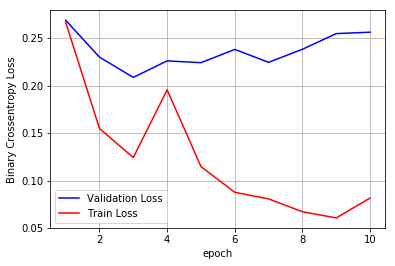

In [30]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

### Stacked LSTM (2-Layer)

In [31]:
# create the model
embedding_vecor_length = 32
model = Sequential()

# This will convert our words (referenced by integers in the data) into meaningful embedding vectors.
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))

model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
epochs = 10
history = model.fit(x_train, y_train, nb_epoch=epochs, batch_size=100, validation_data=(x_test, y_test))
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("======="*15)
print("Test loss: ",scores[0])
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train on 30000 samples, validate on 30000 samples
Epoch 1/10


20300/30000 [===================>..........] - ETA: 20:29 - loss: 0.6932 - acc: 0.54 - ETA: 16:05 - loss: 0.6897 - acc: 0.68 - ETA: 14:33 - loss: 0.6853 - acc: 0.74 - ETA: 13:49 - loss: 0.6797 - acc: 0.77 - ETA: 13:28 - loss: 0.6725 - acc: 0.79 - ETA: 13:14 - loss: 0.6629 - acc: 0.81 - ETA: 13:04 - loss: 0.6516 - acc: 0.82 - ETA: 12:55 - loss: 0.6353 - acc: 0.82 - ETA: 12:48 - loss: 0.6177 - acc: 0.83 - ETA: 12:43 - loss: 0.6007 - acc: 0.83 - ETA: 12:38 - loss: 0.5835 - acc: 0.83 - ETA: 12:33 - loss: 0.5666 - acc: 0.83 - ETA: 12:31 - loss: 0.5406 - acc: 0.84 - ETA: 12:28 - loss: 0.5234 - acc: 0.85 - ETA: 12:24 - loss: 0.5039 - acc: 0.85 - ETA: 12:21 - loss: 0.4956 - acc: 0.85 - ETA: 12:18 - loss: 0.4885 - acc: 0.85 - ETA: 12:15 - loss: 0.4810 - acc: 0.86 - ETA: 12:12 - loss: 0.4807 - acc: 0.85 - ETA: 12:09 - loss: 0.4725 - acc: 0.86 - ETA: 12:05 - loss: 0.4666 - acc: 0.86 - ETA: 12:03 - loss: 0.4631 - acc: 0.86 - ETA: 12:00 - loss: 0.4568 - acc: 0.86 - ETA: 11:58 - loss: 0.4505 - acc: 

30000/30000 [==============================] - ETA: 4:50 - loss: 0.2793 - acc: 0.901 - ETA: 4:47 - loss: 0.2787 - acc: 0.901 - ETA: 4:44 - loss: 0.2789 - acc: 0.901 - ETA: 4:41 - loss: 0.2786 - acc: 0.901 - ETA: 4:39 - loss: 0.2781 - acc: 0.901 - ETA: 4:36 - loss: 0.2778 - acc: 0.901 - ETA: 4:33 - loss: 0.2776 - acc: 0.901 - ETA: 4:30 - loss: 0.2769 - acc: 0.901 - ETA: 4:27 - loss: 0.2764 - acc: 0.901 - ETA: 4:25 - loss: 0.2758 - acc: 0.902 - ETA: 4:22 - loss: 0.2752 - acc: 0.902 - ETA: 4:19 - loss: 0.2745 - acc: 0.902 - ETA: 4:16 - loss: 0.2746 - acc: 0.902 - ETA: 4:13 - loss: 0.2742 - acc: 0.902 - ETA: 4:10 - loss: 0.2743 - acc: 0.902 - ETA: 4:07 - loss: 0.2738 - acc: 0.902 - ETA: 4:04 - loss: 0.2735 - acc: 0.902 - ETA: 4:01 - loss: 0.2731 - acc: 0.902 - ETA: 3:58 - loss: 0.2725 - acc: 0.903 - ETA: 3:55 - loss: 0.2720 - acc: 0.903 - ETA: 3:52 - loss: 0.2716 - acc: 0.903 - ETA: 3:49 - loss: 0.2710 - acc: 0.903 - ETA: 3:46 - loss: 0.2706 - acc: 0.903 - ETA: 3:44 - loss: 0.2703 - acc: 0

20400/30000 [===================>..........] - ETA: 18:35 - loss: 0.0922 - acc: 0.96 - ETA: 18:40 - loss: 0.0980 - acc: 0.97 - ETA: 18:30 - loss: 0.0999 - acc: 0.96 - ETA: 18:27 - loss: 0.0921 - acc: 0.96 - ETA: 18:36 - loss: 0.1136 - acc: 0.95 - ETA: 18:40 - loss: 0.1256 - acc: 0.94 - ETA: 18:44 - loss: 0.1229 - acc: 0.95 - ETA: 18:36 - loss: 0.1368 - acc: 0.94 - ETA: 18:31 - loss: 0.1439 - acc: 0.94 - ETA: 18:25 - loss: 0.1462 - acc: 0.94 - ETA: 18:19 - loss: 0.1411 - acc: 0.94 - ETA: 18:13 - loss: 0.1510 - acc: 0.94 - ETA: 18:07 - loss: 0.1490 - acc: 0.94 - ETA: 18:03 - loss: 0.1460 - acc: 0.94 - ETA: 18:04 - loss: 0.1417 - acc: 0.94 - ETA: 18:04 - loss: 0.1471 - acc: 0.94 - ETA: 18:03 - loss: 0.1455 - acc: 0.94 - ETA: 18:01 - loss: 0.1434 - acc: 0.94 - ETA: 17:59 - loss: 0.1434 - acc: 0.94 - ETA: 18:13 - loss: 0.1428 - acc: 0.94 - ETA: 18:14 - loss: 0.1412 - acc: 0.94 - ETA: 18:09 - loss: 0.1398 - acc: 0.94 - ETA: 18:04 - loss: 0.1419 - acc: 0.94 - ETA: 17:59 - loss: 0.1407 - acc: 

30000/30000 [==============================] - ETA: 6:29 - loss: 0.1429 - acc: 0.946 - ETA: 6:25 - loss: 0.1427 - acc: 0.946 - ETA: 6:21 - loss: 0.1425 - acc: 0.946 - ETA: 6:17 - loss: 0.1427 - acc: 0.946 - ETA: 6:13 - loss: 0.1428 - acc: 0.946 - ETA: 6:08 - loss: 0.1428 - acc: 0.946 - ETA: 6:04 - loss: 0.1429 - acc: 0.946 - ETA: 6:00 - loss: 0.1430 - acc: 0.946 - ETA: 5:56 - loss: 0.1430 - acc: 0.946 - ETA: 5:52 - loss: 0.1431 - acc: 0.946 - ETA: 5:48 - loss: 0.1430 - acc: 0.946 - ETA: 5:44 - loss: 0.1429 - acc: 0.946 - ETA: 5:40 - loss: 0.1427 - acc: 0.946 - ETA: 5:35 - loss: 0.1432 - acc: 0.946 - ETA: 5:31 - loss: 0.1431 - acc: 0.946 - ETA: 5:27 - loss: 0.1432 - acc: 0.946 - ETA: 5:23 - loss: 0.1431 - acc: 0.946 - ETA: 5:19 - loss: 0.1430 - acc: 0.946 - ETA: 5:14 - loss: 0.1425 - acc: 0.946 - ETA: 5:10 - loss: 0.1427 - acc: 0.946 - ETA: 5:06 - loss: 0.1424 - acc: 0.946 - ETA: 5:02 - loss: 0.1423 - acc: 0.946 - ETA: 4:58 - loss: 0.1424 - acc: 0.946 - ETA: 4:53 - loss: 0.1421 - acc: 0

20400/30000 [===================>..........] - ETA: 21:49 - loss: 0.1449 - acc: 0.94 - ETA: 22:16 - loss: 0.1011 - acc: 0.96 - ETA: 22:13 - loss: 0.1054 - acc: 0.95 - ETA: 21:29 - loss: 0.1044 - acc: 0.95 - ETA: 20:55 - loss: 0.0947 - acc: 0.96 - ETA: 20:30 - loss: 0.1062 - acc: 0.95 - ETA: 20:11 - loss: 0.1041 - acc: 0.95 - ETA: 19:55 - loss: 0.1020 - acc: 0.95 - ETA: 19:44 - loss: 0.1107 - acc: 0.95 - ETA: 19:33 - loss: 0.1096 - acc: 0.95 - ETA: 19:22 - loss: 0.1132 - acc: 0.95 - ETA: 19:14 - loss: 0.1187 - acc: 0.95 - ETA: 19:06 - loss: 0.1164 - acc: 0.95 - ETA: 18:59 - loss: 0.1179 - acc: 0.95 - ETA: 18:53 - loss: 0.1226 - acc: 0.95 - ETA: 18:47 - loss: 0.1250 - acc: 0.95 - ETA: 18:41 - loss: 0.1269 - acc: 0.95 - ETA: 18:34 - loss: 0.1262 - acc: 0.95 - ETA: 18:30 - loss: 0.1267 - acc: 0.95 - ETA: 18:24 - loss: 0.1301 - acc: 0.95 - ETA: 18:20 - loss: 0.1277 - acc: 0.95 - ETA: 18:14 - loss: 0.1315 - acc: 0.95 - ETA: 18:09 - loss: 0.1296 - acc: 0.95 - ETA: 18:04 - loss: 0.1298 - acc: 

30000/30000 [==============================] - ETA: 6:10 - loss: 0.1148 - acc: 0.957 - ETA: 6:06 - loss: 0.1151 - acc: 0.957 - ETA: 6:02 - loss: 0.1150 - acc: 0.957 - ETA: 5:58 - loss: 0.1148 - acc: 0.957 - ETA: 5:54 - loss: 0.1147 - acc: 0.957 - ETA: 5:50 - loss: 0.1144 - acc: 0.958 - ETA: 5:46 - loss: 0.1144 - acc: 0.957 - ETA: 5:42 - loss: 0.1148 - acc: 0.957 - ETA: 5:38 - loss: 0.1148 - acc: 0.957 - ETA: 5:35 - loss: 0.1147 - acc: 0.957 - ETA: 5:31 - loss: 0.1147 - acc: 0.958 - ETA: 5:27 - loss: 0.1146 - acc: 0.958 - ETA: 5:23 - loss: 0.1145 - acc: 0.958 - ETA: 5:19 - loss: 0.1153 - acc: 0.957 - ETA: 5:15 - loss: 0.1154 - acc: 0.957 - ETA: 5:11 - loss: 0.1154 - acc: 0.957 - ETA: 5:07 - loss: 0.1157 - acc: 0.957 - ETA: 5:03 - loss: 0.1157 - acc: 0.957 - ETA: 5:00 - loss: 0.1157 - acc: 0.957 - ETA: 4:56 - loss: 0.1156 - acc: 0.957 - ETA: 4:52 - loss: 0.1153 - acc: 0.957 - ETA: 4:48 - loss: 0.1154 - acc: 0.957 - ETA: 4:44 - loss: 0.1157 - acc: 0.957 - ETA: 4:40 - loss: 0.1155 - acc: 0

20400/30000 [===================>..........] - ETA: 19:53 - loss: 0.1061 - acc: 0.96 - ETA: 19:44 - loss: 0.0870 - acc: 0.96 - ETA: 19:37 - loss: 0.0822 - acc: 0.96 - ETA: 19:31 - loss: 0.0670 - acc: 0.97 - ETA: 19:28 - loss: 0.0728 - acc: 0.97 - ETA: 19:23 - loss: 0.0696 - acc: 0.97 - ETA: 19:18 - loss: 0.0636 - acc: 0.97 - ETA: 19:13 - loss: 0.0653 - acc: 0.97 - ETA: 19:08 - loss: 0.0616 - acc: 0.97 - ETA: 19:04 - loss: 0.0575 - acc: 0.98 - ETA: 19:00 - loss: 0.0561 - acc: 0.98 - ETA: 18:56 - loss: 0.0539 - acc: 0.98 - ETA: 18:52 - loss: 0.0625 - acc: 0.97 - ETA: 18:48 - loss: 0.0727 - acc: 0.97 - ETA: 18:44 - loss: 0.0753 - acc: 0.97 - ETA: 18:40 - loss: 0.0789 - acc: 0.97 - ETA: 18:36 - loss: 0.0778 - acc: 0.97 - ETA: 18:32 - loss: 0.0771 - acc: 0.97 - ETA: 18:29 - loss: 0.0806 - acc: 0.97 - ETA: 18:25 - loss: 0.0820 - acc: 0.97 - ETA: 18:21 - loss: 0.0824 - acc: 0.97 - ETA: 18:17 - loss: 0.0881 - acc: 0.97 - ETA: 18:13 - loss: 0.0884 - acc: 0.96 - ETA: 18:09 - loss: 0.0868 - acc: 

30000/30000 [==============================] - ETA: 6:17 - loss: 0.0924 - acc: 0.968 - ETA: 6:13 - loss: 0.0922 - acc: 0.968 - ETA: 6:09 - loss: 0.0922 - acc: 0.968 - ETA: 6:05 - loss: 0.0925 - acc: 0.968 - ETA: 6:01 - loss: 0.0927 - acc: 0.968 - ETA: 5:57 - loss: 0.0929 - acc: 0.968 - ETA: 5:53 - loss: 0.0932 - acc: 0.968 - ETA: 5:49 - loss: 0.0933 - acc: 0.968 - ETA: 5:45 - loss: 0.0931 - acc: 0.968 - ETA: 5:41 - loss: 0.0932 - acc: 0.968 - ETA: 5:37 - loss: 0.0933 - acc: 0.968 - ETA: 5:33 - loss: 0.0937 - acc: 0.968 - ETA: 5:29 - loss: 0.0938 - acc: 0.968 - ETA: 5:25 - loss: 0.0939 - acc: 0.968 - ETA: 5:21 - loss: 0.0945 - acc: 0.967 - ETA: 5:17 - loss: 0.0943 - acc: 0.967 - ETA: 5:13 - loss: 0.0943 - acc: 0.967 - ETA: 5:09 - loss: 0.0942 - acc: 0.967 - ETA: 5:05 - loss: 0.0945 - acc: 0.967 - ETA: 5:01 - loss: 0.0945 - acc: 0.967 - ETA: 4:57 - loss: 0.0944 - acc: 0.967 - ETA: 4:53 - loss: 0.0946 - acc: 0.967 - ETA: 4:49 - loss: 0.0946 - acc: 0.967 - ETA: 4:45 - loss: 0.0946 - acc: 0

20400/30000 [===================>..........] - ETA: 19:50 - loss: 0.1697 - acc: 0.94 - ETA: 19:40 - loss: 0.1092 - acc: 0.96 - ETA: 19:36 - loss: 0.1178 - acc: 0.95 - ETA: 19:31 - loss: 0.1050 - acc: 0.95 - ETA: 19:29 - loss: 0.0908 - acc: 0.96 - ETA: 19:25 - loss: 0.1095 - acc: 0.96 - ETA: 19:21 - loss: 0.1039 - acc: 0.96 - ETA: 19:17 - loss: 0.0949 - acc: 0.96 - ETA: 19:13 - loss: 0.0868 - acc: 0.97 - ETA: 19:09 - loss: 0.0841 - acc: 0.97 - ETA: 19:05 - loss: 0.0838 - acc: 0.97 - ETA: 19:01 - loss: 0.0837 - acc: 0.97 - ETA: 18:58 - loss: 0.0808 - acc: 0.97 - ETA: 18:54 - loss: 0.0790 - acc: 0.97 - ETA: 18:52 - loss: 0.0785 - acc: 0.97 - ETA: 18:48 - loss: 0.0792 - acc: 0.97 - ETA: 18:44 - loss: 0.0771 - acc: 0.97 - ETA: 18:40 - loss: 0.0742 - acc: 0.97 - ETA: 18:36 - loss: 0.0720 - acc: 0.97 - ETA: 18:32 - loss: 0.0712 - acc: 0.97 - ETA: 18:28 - loss: 0.0725 - acc: 0.97 - ETA: 18:24 - loss: 0.0710 - acc: 0.97 - ETA: 18:20 - loss: 0.0720 - acc: 0.97 - ETA: 18:16 - loss: 0.0711 - acc: 

30000/30000 [==============================] - ETA: 6:19 - loss: 0.0878 - acc: 0.968 - ETA: 6:15 - loss: 0.0877 - acc: 0.968 - ETA: 6:11 - loss: 0.0873 - acc: 0.968 - ETA: 6:07 - loss: 0.0871 - acc: 0.968 - ETA: 6:03 - loss: 0.0870 - acc: 0.968 - ETA: 5:59 - loss: 0.0869 - acc: 0.968 - ETA: 5:55 - loss: 0.0871 - acc: 0.968 - ETA: 5:51 - loss: 0.0870 - acc: 0.968 - ETA: 5:47 - loss: 0.0870 - acc: 0.968 - ETA: 5:43 - loss: 0.0869 - acc: 0.968 - ETA: 5:39 - loss: 0.0871 - acc: 0.968 - ETA: 5:35 - loss: 0.0872 - acc: 0.968 - ETA: 5:31 - loss: 0.0871 - acc: 0.968 - ETA: 5:27 - loss: 0.0873 - acc: 0.968 - ETA: 5:23 - loss: 0.0873 - acc: 0.968 - ETA: 5:19 - loss: 0.0878 - acc: 0.968 - ETA: 5:15 - loss: 0.0877 - acc: 0.968 - ETA: 5:11 - loss: 0.0877 - acc: 0.967 - ETA: 5:07 - loss: 0.0873 - acc: 0.968 - ETA: 5:03 - loss: 0.0875 - acc: 0.968 - ETA: 4:59 - loss: 0.0873 - acc: 0.968 - ETA: 4:55 - loss: 0.0871 - acc: 0.968 - ETA: 4:51 - loss: 0.0869 - acc: 0.968 - ETA: 4:47 - loss: 0.0869 - acc: 0

20400/30000 [===================>..........] - ETA: 20:50 - loss: 0.0571 - acc: 0.98 - ETA: 20:18 - loss: 0.0729 - acc: 0.98 - ETA: 20:03 - loss: 0.0564 - acc: 0.99 - ETA: 19:57 - loss: 0.0536 - acc: 0.99 - ETA: 19:51 - loss: 0.0569 - acc: 0.99 - ETA: 19:45 - loss: 0.0504 - acc: 0.99 - ETA: 19:39 - loss: 0.0559 - acc: 0.98 - ETA: 19:35 - loss: 0.0552 - acc: 0.98 - ETA: 19:30 - loss: 0.0525 - acc: 0.98 - ETA: 19:25 - loss: 0.0546 - acc: 0.98 - ETA: 19:21 - loss: 0.0542 - acc: 0.98 - ETA: 19:16 - loss: 0.0559 - acc: 0.98 - ETA: 19:12 - loss: 0.0659 - acc: 0.98 - ETA: 19:07 - loss: 0.0627 - acc: 0.98 - ETA: 19:04 - loss: 0.0655 - acc: 0.98 - ETA: 19:00 - loss: 0.0634 - acc: 0.98 - ETA: 18:55 - loss: 0.0641 - acc: 0.98 - ETA: 18:51 - loss: 0.0643 - acc: 0.98 - ETA: 18:47 - loss: 0.0634 - acc: 0.98 - ETA: 18:42 - loss: 0.0643 - acc: 0.98 - ETA: 18:38 - loss: 0.0654 - acc: 0.98 - ETA: 18:34 - loss: 0.0645 - acc: 0.98 - ETA: 18:31 - loss: 0.0663 - acc: 0.98 - ETA: 18:27 - loss: 0.0646 - acc: 

30000/30000 [==============================] - ETA: 6:21 - loss: 0.0651 - acc: 0.978 - ETA: 6:17 - loss: 0.0651 - acc: 0.978 - ETA: 6:13 - loss: 0.0651 - acc: 0.978 - ETA: 6:09 - loss: 0.0652 - acc: 0.978 - ETA: 6:05 - loss: 0.0652 - acc: 0.978 - ETA: 6:01 - loss: 0.0656 - acc: 0.978 - ETA: 5:57 - loss: 0.0656 - acc: 0.978 - ETA: 5:52 - loss: 0.0659 - acc: 0.978 - ETA: 5:48 - loss: 0.0658 - acc: 0.978 - ETA: 5:44 - loss: 0.0659 - acc: 0.977 - ETA: 5:40 - loss: 0.0661 - acc: 0.977 - ETA: 5:36 - loss: 0.0661 - acc: 0.977 - ETA: 5:32 - loss: 0.0661 - acc: 0.978 - ETA: 5:28 - loss: 0.0659 - acc: 0.978 - ETA: 5:24 - loss: 0.0661 - acc: 0.977 - ETA: 5:20 - loss: 0.0663 - acc: 0.977 - ETA: 5:16 - loss: 0.0665 - acc: 0.977 - ETA: 5:12 - loss: 0.0669 - acc: 0.977 - ETA: 5:08 - loss: 0.0668 - acc: 0.977 - ETA: 5:04 - loss: 0.0666 - acc: 0.977 - ETA: 5:00 - loss: 0.0667 - acc: 0.977 - ETA: 4:56 - loss: 0.0671 - acc: 0.977 - ETA: 4:52 - loss: 0.0672 - acc: 0.977 - ETA: 4:48 - loss: 0.0670 - acc: 0

20400/30000 [===================>..........] - ETA: 20:24 - loss: 0.0197 - acc: 1.00 - ETA: 20:05 - loss: 0.0405 - acc: 0.99 - ETA: 19:57 - loss: 0.0409 - acc: 0.99 - ETA: 19:51 - loss: 0.0388 - acc: 0.99 - ETA: 19:45 - loss: 0.0394 - acc: 0.99 - ETA: 19:38 - loss: 0.0405 - acc: 0.99 - ETA: 19:34 - loss: 0.0362 - acc: 0.99 - ETA: 19:30 - loss: 0.0406 - acc: 0.99 - ETA: 19:26 - loss: 0.0390 - acc: 0.99 - ETA: 19:21 - loss: 0.0405 - acc: 0.99 - ETA: 19:17 - loss: 0.0392 - acc: 0.99 - ETA: 19:13 - loss: 0.0420 - acc: 0.98 - ETA: 19:09 - loss: 0.0459 - acc: 0.98 - ETA: 19:05 - loss: 0.0474 - acc: 0.98 - ETA: 19:00 - loss: 0.0452 - acc: 0.98 - ETA: 18:56 - loss: 0.0466 - acc: 0.98 - ETA: 18:52 - loss: 0.0446 - acc: 0.98 - ETA: 18:48 - loss: 0.0448 - acc: 0.98 - ETA: 18:44 - loss: 0.0489 - acc: 0.98 - ETA: 18:39 - loss: 0.0474 - acc: 0.98 - ETA: 18:38 - loss: 0.0467 - acc: 0.98 - ETA: 18:34 - loss: 0.0469 - acc: 0.98 - ETA: 18:30 - loss: 0.0463 - acc: 0.98 - ETA: 18:26 - loss: 0.0460 - acc: 

30000/30000 [==============================] - ETA: 6:20 - loss: 0.0570 - acc: 0.981 - ETA: 6:16 - loss: 0.0572 - acc: 0.981 - ETA: 6:12 - loss: 0.0570 - acc: 0.981 - ETA: 6:08 - loss: 0.0568 - acc: 0.981 - ETA: 6:04 - loss: 0.0568 - acc: 0.981 - ETA: 6:00 - loss: 0.0570 - acc: 0.981 - ETA: 5:56 - loss: 0.0569 - acc: 0.981 - ETA: 5:52 - loss: 0.0569 - acc: 0.981 - ETA: 5:48 - loss: 0.0572 - acc: 0.981 - ETA: 5:44 - loss: 0.0570 - acc: 0.981 - ETA: 5:40 - loss: 0.0569 - acc: 0.981 - ETA: 5:36 - loss: 0.0575 - acc: 0.981 - ETA: 5:32 - loss: 0.0572 - acc: 0.981 - ETA: 5:28 - loss: 0.0571 - acc: 0.981 - ETA: 5:24 - loss: 0.0571 - acc: 0.981 - ETA: 5:20 - loss: 0.0572 - acc: 0.981 - ETA: 5:16 - loss: 0.0574 - acc: 0.981 - ETA: 5:12 - loss: 0.0573 - acc: 0.981 - ETA: 5:08 - loss: 0.0574 - acc: 0.981 - ETA: 5:04 - loss: 0.0574 - acc: 0.981 - ETA: 5:00 - loss: 0.0574 - acc: 0.981 - ETA: 4:56 - loss: 0.0575 - acc: 0.981 - ETA: 4:52 - loss: 0.0579 - acc: 0.981 - ETA: 4:48 - loss: 0.0579 - acc: 0

20400/30000 [===================>..........] - ETA: 20:03 - loss: 0.0601 - acc: 0.98 - ETA: 19:52 - loss: 0.0428 - acc: 0.99 - ETA: 19:45 - loss: 0.0432 - acc: 0.99 - ETA: 19:40 - loss: 0.0449 - acc: 0.99 - ETA: 19:37 - loss: 0.0408 - acc: 0.99 - ETA: 19:33 - loss: 0.0366 - acc: 0.99 - ETA: 19:28 - loss: 0.0362 - acc: 0.99 - ETA: 19:25 - loss: 0.0333 - acc: 0.99 - ETA: 19:23 - loss: 0.0338 - acc: 0.99 - ETA: 19:19 - loss: 0.0529 - acc: 0.98 - ETA: 19:15 - loss: 0.0530 - acc: 0.98 - ETA: 19:12 - loss: 0.0513 - acc: 0.98 - ETA: 19:08 - loss: 0.0508 - acc: 0.98 - ETA: 19:03 - loss: 0.0517 - acc: 0.98 - ETA: 18:59 - loss: 0.0537 - acc: 0.98 - ETA: 18:56 - loss: 0.0527 - acc: 0.98 - ETA: 18:52 - loss: 0.0514 - acc: 0.98 - ETA: 18:47 - loss: 0.0496 - acc: 0.98 - ETA: 18:43 - loss: 0.0516 - acc: 0.98 - ETA: 18:40 - loss: 0.0528 - acc: 0.98 - ETA: 18:36 - loss: 0.0526 - acc: 0.98 - ETA: 18:31 - loss: 0.0510 - acc: 0.98 - ETA: 18:27 - loss: 0.0532 - acc: 0.98 - ETA: 18:23 - loss: 0.0517 - acc: 

30000/30000 [==============================] - ETA: 6:21 - loss: 0.0520 - acc: 0.983 - ETA: 6:17 - loss: 0.0519 - acc: 0.983 - ETA: 6:13 - loss: 0.0518 - acc: 0.983 - ETA: 6:09 - loss: 0.0517 - acc: 0.983 - ETA: 6:05 - loss: 0.0520 - acc: 0.982 - ETA: 6:01 - loss: 0.0522 - acc: 0.982 - ETA: 5:57 - loss: 0.0523 - acc: 0.982 - ETA: 5:53 - loss: 0.0523 - acc: 0.982 - ETA: 5:49 - loss: 0.0525 - acc: 0.982 - ETA: 5:45 - loss: 0.0523 - acc: 0.982 - ETA: 5:41 - loss: 0.0522 - acc: 0.982 - ETA: 5:37 - loss: 0.0521 - acc: 0.982 - ETA: 5:33 - loss: 0.0523 - acc: 0.982 - ETA: 5:29 - loss: 0.0524 - acc: 0.982 - ETA: 5:25 - loss: 0.0522 - acc: 0.982 - ETA: 5:21 - loss: 0.0521 - acc: 0.982 - ETA: 5:17 - loss: 0.0519 - acc: 0.982 - ETA: 5:12 - loss: 0.0520 - acc: 0.982 - ETA: 5:08 - loss: 0.0519 - acc: 0.982 - ETA: 5:04 - loss: 0.0519 - acc: 0.982 - ETA: 5:00 - loss: 0.0520 - acc: 0.982 - ETA: 4:56 - loss: 0.0523 - acc: 0.982 - ETA: 4:52 - loss: 0.0522 - acc: 0.982 - ETA: 4:48 - loss: 0.0521 - acc: 0

20400/30000 [===================>..........] - ETA: 20:03 - loss: 0.0258 - acc: 0.99 - ETA: 19:57 - loss: 0.0156 - acc: 0.99 - ETA: 19:48 - loss: 0.0339 - acc: 0.99 - ETA: 19:49 - loss: 0.0272 - acc: 0.99 - ETA: 19:43 - loss: 0.0247 - acc: 0.99 - ETA: 19:38 - loss: 0.0239 - acc: 0.99 - ETA: 19:33 - loss: 0.0268 - acc: 0.99 - ETA: 19:29 - loss: 0.0245 - acc: 0.99 - ETA: 19:25 - loss: 0.0240 - acc: 0.99 - ETA: 19:21 - loss: 0.0231 - acc: 0.99 - ETA: 19:16 - loss: 0.0252 - acc: 0.99 - ETA: 19:12 - loss: 0.0300 - acc: 0.99 - ETA: 19:08 - loss: 0.0283 - acc: 0.99 - ETA: 19:04 - loss: 0.0312 - acc: 0.99 - ETA: 19:00 - loss: 0.0293 - acc: 0.99 - ETA: 18:57 - loss: 0.0313 - acc: 0.99 - ETA: 18:55 - loss: 0.0302 - acc: 0.99 - ETA: 18:50 - loss: 0.0290 - acc: 0.99 - ETA: 18:46 - loss: 0.0284 - acc: 0.99 - ETA: 18:42 - loss: 0.0308 - acc: 0.99 - ETA: 18:37 - loss: 0.0295 - acc: 0.99 - ETA: 18:33 - loss: 0.0315 - acc: 0.99 - ETA: 18:29 - loss: 0.0306 - acc: 0.99 - ETA: 18:25 - loss: 0.0298 - acc: 

30000/30000 [==============================] - ETA: 6:21 - loss: 0.0419 - acc: 0.986 - ETA: 6:17 - loss: 0.0420 - acc: 0.986 - ETA: 6:13 - loss: 0.0423 - acc: 0.986 - ETA: 6:09 - loss: 0.0424 - acc: 0.986 - ETA: 6:05 - loss: 0.0425 - acc: 0.986 - ETA: 6:00 - loss: 0.0424 - acc: 0.986 - ETA: 5:56 - loss: 0.0426 - acc: 0.986 - ETA: 5:52 - loss: 0.0425 - acc: 0.986 - ETA: 5:48 - loss: 0.0423 - acc: 0.986 - ETA: 5:44 - loss: 0.0422 - acc: 0.986 - ETA: 5:40 - loss: 0.0421 - acc: 0.986 - ETA: 5:36 - loss: 0.0421 - acc: 0.986 - ETA: 5:32 - loss: 0.0420 - acc: 0.986 - ETA: 5:28 - loss: 0.0419 - acc: 0.986 - ETA: 5:24 - loss: 0.0418 - acc: 0.986 - ETA: 5:20 - loss: 0.0417 - acc: 0.986 - ETA: 5:16 - loss: 0.0419 - acc: 0.986 - ETA: 5:12 - loss: 0.0418 - acc: 0.986 - ETA: 5:08 - loss: 0.0420 - acc: 0.986 - ETA: 5:04 - loss: 0.0420 - acc: 0.986 - ETA: 5:00 - loss: 0.0420 - acc: 0.986 - ETA: 4:56 - loss: 0.0419 - acc: 0.986 - ETA: 4:52 - loss: 0.0421 - acc: 0.986 - ETA: 4:48 - loss: 0.0420 - acc: 0

20400/30000 [===================>..........] - ETA: 20:03 - loss: 0.0402 - acc: 0.97 - ETA: 19:59 - loss: 0.0236 - acc: 0.98 - ETA: 19:51 - loss: 0.0183 - acc: 0.99 - ETA: 19:48 - loss: 0.0177 - acc: 0.99 - ETA: 19:42 - loss: 0.0162 - acc: 0.99 - ETA: 19:38 - loss: 0.0202 - acc: 0.99 - ETA: 19:32 - loss: 0.0200 - acc: 0.99 - ETA: 19:27 - loss: 0.0183 - acc: 0.99 - ETA: 19:27 - loss: 0.0185 - acc: 0.99 - ETA: 19:22 - loss: 0.0182 - acc: 0.99 - ETA: 19:23 - loss: 0.0209 - acc: 0.99 - ETA: 19:18 - loss: 0.0217 - acc: 0.99 - ETA: 19:13 - loss: 0.0225 - acc: 0.99 - ETA: 19:08 - loss: 0.0227 - acc: 0.99 - ETA: 19:05 - loss: 0.0237 - acc: 0.99 - ETA: 19:02 - loss: 0.0265 - acc: 0.99 - ETA: 18:57 - loss: 0.0261 - acc: 0.99 - ETA: 18:53 - loss: 0.0251 - acc: 0.99 - ETA: 18:49 - loss: 0.0247 - acc: 0.99 - ETA: 18:44 - loss: 0.0292 - acc: 0.99 - ETA: 18:40 - loss: 0.0281 - acc: 0.99 - ETA: 18:36 - loss: 0.0281 - acc: 0.99 - ETA: 18:32 - loss: 0.0279 - acc: 0.99 - ETA: 18:28 - loss: 0.0274 - acc: 

30000/30000 [==============================] - ETA: 6:20 - loss: 0.0378 - acc: 0.988 - ETA: 6:16 - loss: 0.0377 - acc: 0.988 - ETA: 6:12 - loss: 0.0378 - acc: 0.988 - ETA: 6:08 - loss: 0.0377 - acc: 0.988 - ETA: 6:04 - loss: 0.0378 - acc: 0.988 - ETA: 6:00 - loss: 0.0378 - acc: 0.988 - ETA: 5:56 - loss: 0.0377 - acc: 0.988 - ETA: 5:52 - loss: 0.0378 - acc: 0.988 - ETA: 5:48 - loss: 0.0378 - acc: 0.988 - ETA: 5:44 - loss: 0.0376 - acc: 0.988 - ETA: 5:40 - loss: 0.0377 - acc: 0.988 - ETA: 5:36 - loss: 0.0376 - acc: 0.988 - ETA: 5:32 - loss: 0.0376 - acc: 0.988 - ETA: 5:28 - loss: 0.0376 - acc: 0.988 - ETA: 5:24 - loss: 0.0379 - acc: 0.988 - ETA: 5:20 - loss: 0.0378 - acc: 0.988 - ETA: 5:16 - loss: 0.0376 - acc: 0.988 - ETA: 5:12 - loss: 0.0375 - acc: 0.988 - ETA: 5:08 - loss: 0.0380 - acc: 0.988 - ETA: 5:04 - loss: 0.0381 - acc: 0.987 - ETA: 5:00 - loss: 0.0380 - acc: 0.988 - ETA: 4:56 - loss: 0.0379 - acc: 0.988 - ETA: 4:52 - loss: 0.0380 - acc: 0.988 - ETA: 4:48 - loss: 0.0380 - acc: 0

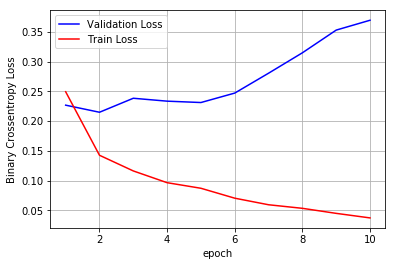

In [33]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, fig)

In [34]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Architecture","Test score","Test accuracy"]

x.add_row(["1 Layer",0.25,92.12])
x.add_row(["2 Layer",0.36,91.33])


print(x)

+--------------+------------+---------------+
| Architecture | Test score | Test accuracy |
+--------------+------------+---------------+
|   1 Layer    |    0.25    |     92.12     |
|   2 Layer    |    0.36    |     91.33     |
+--------------+------------+---------------+
